In [1]:
# Librairies imports
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Hyperparameters
IMAGE_SIZE = 256
BATCH_SIZE = 32
VAL_SPLIT = 0.2
TEST_SPLIT = 0.1
CHANNELS=3
EPOCHS=50

Import the datasets and change it into tensorflow dataset object:
- Source of the dataset: https://www.kaggle.com/datasets/faysalmiah1721758/potato-dataset

In [3]:
data_dir = "Datasets"
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    seed = 42,
    label_mode='int',
    validation_split=None,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [4]:
# Name of the classes
class_names = dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


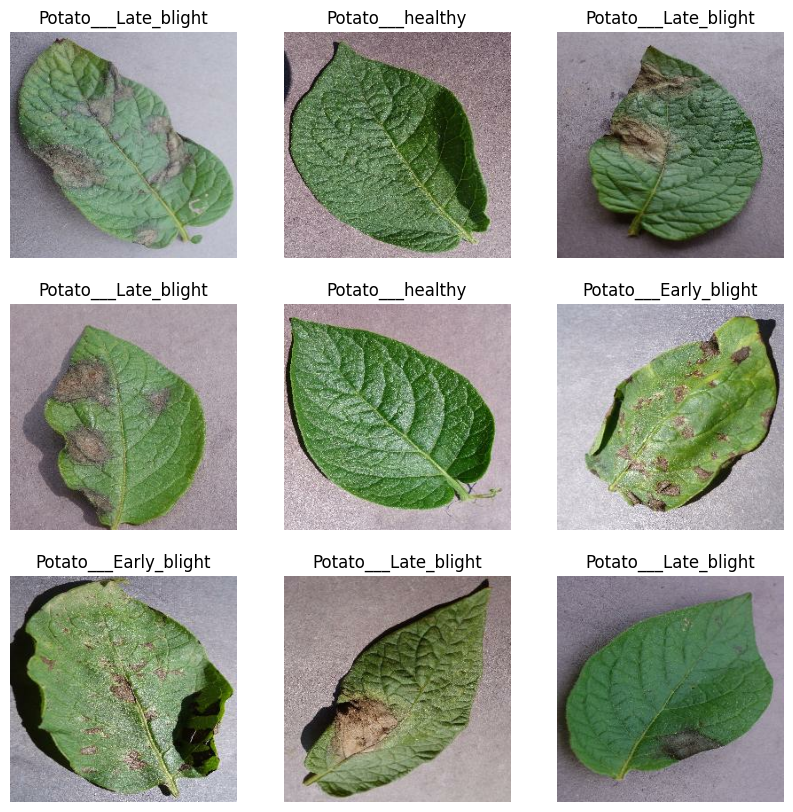

In [5]:
# Visualize the data
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
# Display the shape of batched train samples
for image_batch, labels_batch in dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


Split the dataset into the training, testing and the validation subsets

In [7]:
def subset_creation(dataset, train_split=0.7, test_split=0.1, val_split=0.2, shuffle=True, shuffle_size=100):

    assert (train_split + test_split + val_split) == 1

    size_dataset = len(dataset)

    if shuffle:
            dataset = dataset.shuffle(shuffle_size, seed=123)
    
    train_size = int(size_dataset * train_split)
    test_size = int(size_dataset * test_split)
    val_size = int(size_dataset * val_split)


    train_dataset = dataset.take(train_size)
    test_dataset = dataset.skip(train_size).take(test_size)
    val_dataset = dataset.skip(test_size).take(val_size)

    return train_dataset, val_dataset, test_dataset

    


In [8]:
train_ds, val_ds, test_ds = subset_creation(dataset)

In [9]:
print(f"""
    ----------------------------------
    Dataset split:
        - train split: {len(train_ds)}
        - val split: {len(val_ds)}
        - test split: {len(test_ds)}
    ----------------------------------
    """
)


    ----------------------------------
    Dataset split:
        - train split: 47
        - val split: 13
        - test split: 6
    ----------------------------------
    


Cache the dataset

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Normalization and Resizing of the images for prediction

In [11]:

resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1./255),
])

Proof that the images are rescaled

In [12]:
normalized_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [13]:
# Import keras api 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

Image augmentation

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  #tf.keras.layers.RandomContrast(0.2),
  #tf.keras.layers.RandomCrop(height=1, width=1),
  #tf.keras.layers.RandomZoom(0.2),
  #tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
  #tf.keras.layers.RandomBrightness(factor=0.2)
])

In [15]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Model creation

In [16]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = tf.keras.models.Sequential([
    resize_and_rescale,
    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(CHANNELS, activation='softmax'),
])

model.build(input_shape=input_shape)

c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [61]:
filepath="model/best_model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=10)
callbacks_list = [checkpoint, es]

In [62]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    callbacks=callbacks_list
)

Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node LogicalAnd defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\asyncio\base_events.py", line 618, in run_forever

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\asyncio\base_events.py", line 1951, in _run_once

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\asyncio\events.py", line 84, in _run

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\Ronan\AppData\Local\Temp\ipykernel_7688\239765465.py", line 1, in <module>

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 314, in fit

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 117, in one_step_on_iterator

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 104, in one_step_on_data

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 73, in train_step

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\keras\src\trainers\trainer.py", line 412, in compute_metrics

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\keras\src\trainers\compile_utils.py", line 330, in update_state

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\keras\src\trainers\compile_utils.py", line 17, in update_state

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\keras\src\metrics\confusion_metrics.py", line 56, in update_state

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\keras\src\metrics\metrics_utils.py", line 592, in update_confusion_matrix_variables

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\keras\src\metrics\metrics_utils.py", line 565, in weighted_assign_add

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\keras\src\ops\numpy.py", line 3242, in logical_and

  File "c:\Users\Ronan\Documents\ML\CNN\Potato_Disease_Classification_Project\venv\Lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 1409, in logical_and

Incompatible shapes: [1,96] vs. [1,32]
	 [[{{node LogicalAnd}}]] [Op:__inference_one_step_on_iterator_30935]

In [21]:
scores = model.evaluate(test_ds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9574 - loss: 0.1268


False Negatives

In [68]:
m = tf.keras.metrics.FalseNegatives()
m.update_state([0, 1, 1, 1], [0, 1, 0, 0])

result = m.result()

In [71]:
print(result)

tf.Tensor(2.0, shape=(), dtype=float32)


In [27]:
print("Accuracy: %.2f%%"% (scores[1]*100))

Accuracy: 94.79%


In [23]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 47}

In [29]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [24]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8938358426094055,
 0.6784921288490295,
 0.4464692175388336,
 0.272481769323349,
 0.26121786236763]

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [44]:
acc

[0.49202126264572144,
 0.6821808218955994,
 0.813829779624939,
 0.8876329660415649,
 0.8996010422706604,
 0.9082446694374084,
 0.927526593208313,
 0.9222074747085571,
 0.907579779624939,
 0.9202127456665039,
 0.9255319237709045,
 0.9255319237709045,
 0.9242021441459656,
 0.9527925252914429,
 0.9541223645210266,
 0.9494680762290955,
 0.9554521441459656,
 0.9647606611251831,
 0.9468085169792175,
 0.9660904407501221,
 0.9714095592498779]

In [45]:
val_acc

[0.598557710647583,
 0.7355769276618958,
 0.8317307829856873,
 0.875,
 0.9086538553237915,
 0.8990384340286255,
 0.8894230723381042,
 0.9230769276618958,
 0.8269230723381042,
 0.807692289352417,
 0.9350961446762085,
 0.901442289352417,
 0.8725961446762085,
 0.9302884340286255,
 0.9158653616905212,
 0.9495192170143127,
 0.8942307829856873,
 0.879807710647583,
 0.942307710647583,
 0.9182692170143127,
 0.9350961446762085]

In [46]:
loss

[0.8938358426094055,
 0.6784921288490295,
 0.4464692175388336,
 0.272481769323349,
 0.26121786236763,
 0.23660221695899963,
 0.188936248421669,
 0.19639283418655396,
 0.2336902767419815,
 0.208577498793602,
 0.18254892528057098,
 0.20158962905406952,
 0.17823068797588348,
 0.13179512321949005,
 0.11544106900691986,
 0.12247716635465622,
 0.10009617358446121,
 0.09102286398410797,
 0.14631329476833344,
 0.09570559114217758,
 0.07297330349683762]

In [47]:
val_loss

[0.8767642378807068,
 0.6378495693206787,
 0.38934585452079773,
 0.297834575176239,
 0.24972836673259735,
 0.21605396270751953,
 0.2959797978401184,
 0.19280284643173218,
 0.3600578010082245,
 0.599565863609314,
 0.18978367745876312,
 0.2384844869375229,
 0.3006160855293274,
 0.15931662917137146,
 0.1707480102777481,
 0.13819462060928345,
 0.237363800406456,
 0.3333944082260132,
 0.15325039625167847,
 0.1908368170261383,
 0.22087812423706055]

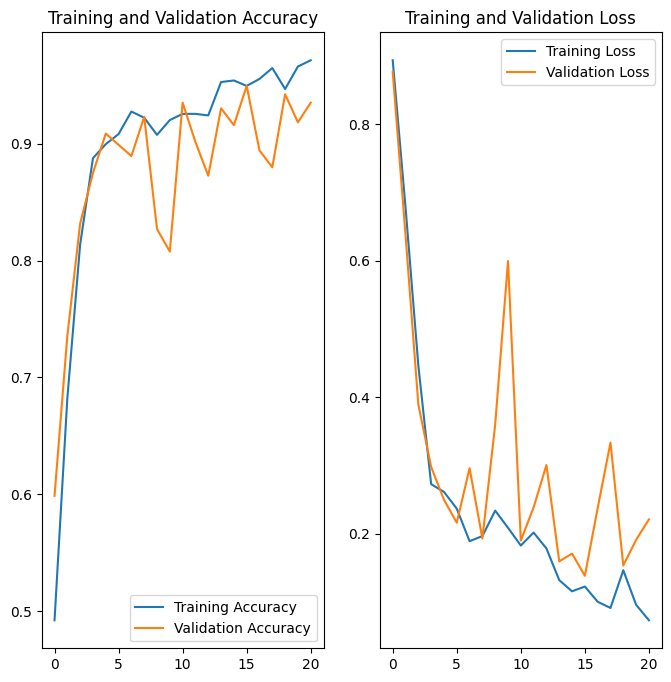

In [48]:
ES_EPOCH = 21

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(ES_EPOCH), acc, label='Training Accuracy')
plt.plot(range(ES_EPOCH), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(ES_EPOCH), loss, label='Training Loss')
plt.plot(range(ES_EPOCH), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
predicted label: Potato___Late_blight


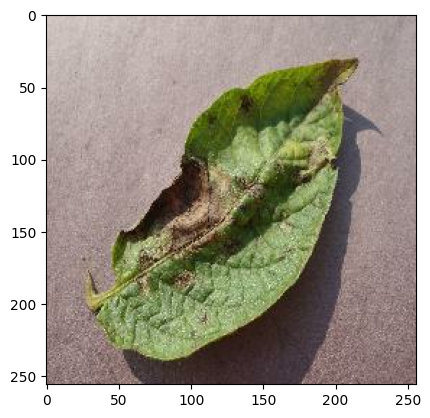

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [39]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


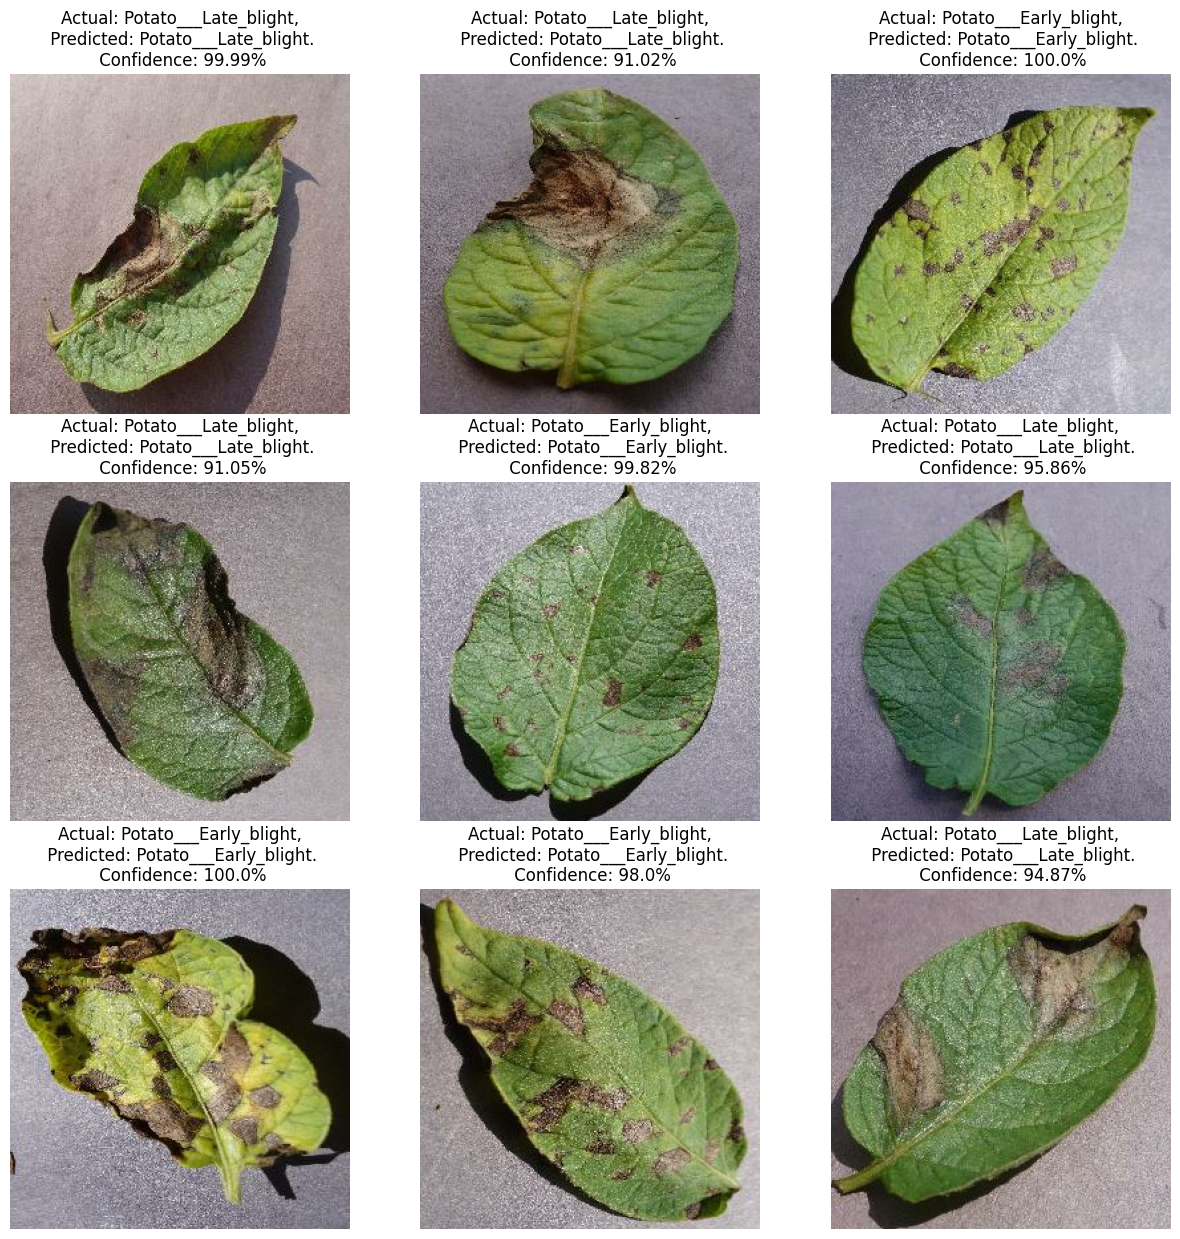

In [52]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
pred = []
for i in range(192):
    pred.append()

In [54]:
predicted_class

'Potato___Late_blight'